# Data analytics for home appliances identification
_by Ayush Garg, Gabriel Vizcaino and Pradeep Somi Ganeshbabu_

### Table of content
- [Loading and processing the PLAID dataset](#Loading-and-processing-the-PLAID-dataset)
- [Saving or loading the processed dataset](#Saving-or-loading-the-processed-dataset) 
- [Fitting the classifier](Fitting-the-classifier)
- [Testing the accuracy of the chosen classifiers](#Testing-the-accuracy-of-the-chosen-classifiers)
- [Identifying appliance type per house](#Identifying-appliance-type-per-house)
- [Conclusions and future work](#Conclusions-and-future-work)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, time, seaborn, random, pandas as pd
from IPython.display import display
%matplotlib inline
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier

### Loading and processing the PLAID dataset

In [ ]:
# .....Ayush

In [2]:
##### ----------------Erase----------------------------------------
# pkf = open('Data_matrices.pkl','rb')
# V_org,I_org,y_org,org_ids,houses = pickle.load(pkf)
pkf = open('AppData.pkl','rb')
data = pickle.load(pkf)
pkf.close()

To facilitate working with the data, we extract the data contained in the dictionary `data` and create the following variables:
- V_org: Matrix of orginal voltage signals collected from every appliance (1074x30000)
- I_org: Matrix of originla current signals collected from every appliance (1074x30000)
- types: List of the types of appliances available in the dataset in alphabetic order 
- y_org: Array of numerical encoding for each appliance type (1074x1)
- org_ids: List of original identification number of each appliance in the dataset
- house: Matrix of the identification number of each appliance and the corresponding house name

In [3]:
types = sorted(list(data.keys()))
cycle = 30000; num_cycles = 1; till = -cycle*num_cycles
resh = np.int(-till/num_cycles); tot = np.sum([len(data[x]) for x in data]); org_ids,c = [], 0
V = np.empty([resh,tot]); I = np.empty([resh,tot]); y = np.zeros(tot)
for ap_num,ap in enumerate(types):
    for i in data[ap]:
        V[:,c] = np.mean(np.reshape(data[ap][i]['voltage'][till:],(-1,cycle)),axis=0)
        I[:,c] = np.mean(np.reshape(data[ap][i]['current'][till:],(-1,cycle)),axis=0)
        y[c] = ap_num
        org_ids.append(i)
        c += 1
    pass
V_org = V.T; I_org = I.T

In order to identify identify patterns, it is useful to plot the data first. The following script plots the V-I profile of the last 10 cycles of five randomly picked appliances of each type.

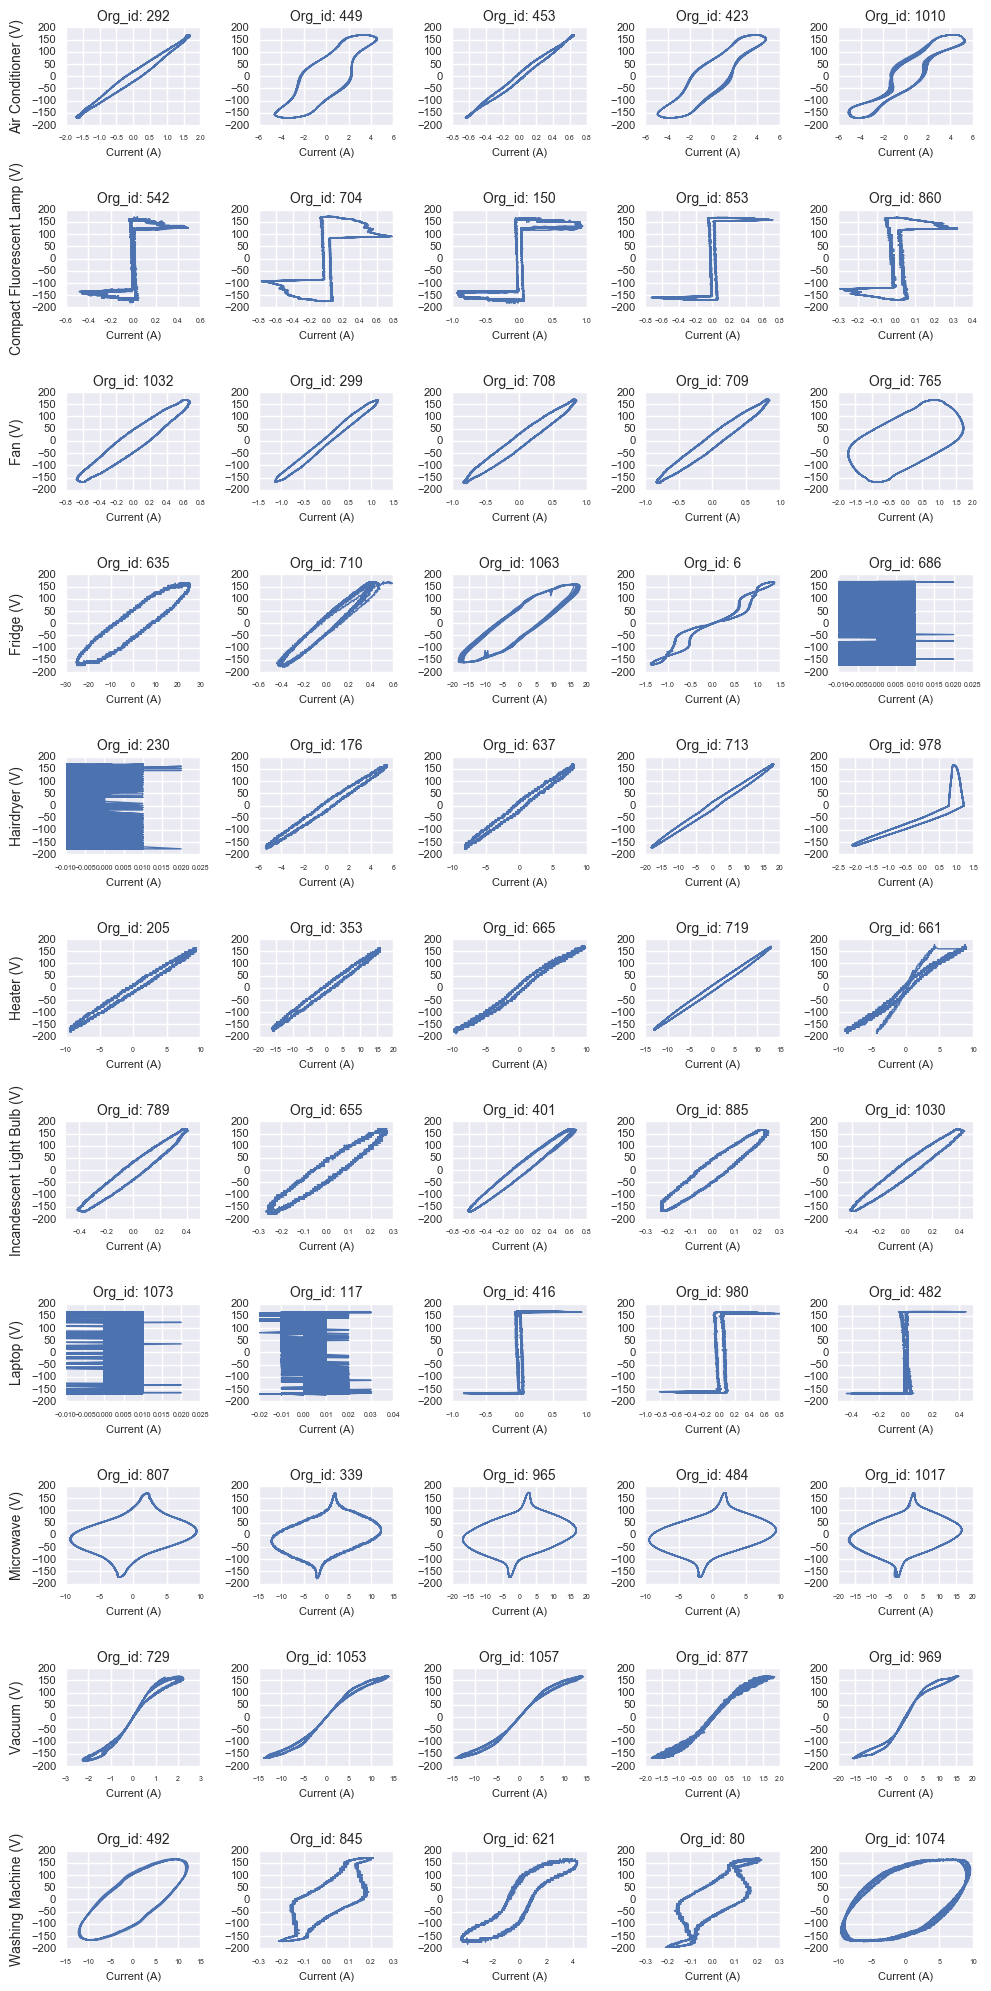

In [11]:
# plot V-I of last 10 steady state periods
num_figs = 5; fig, ax = plt.subplots(len(types),num_figs,figsize=(10,20)); till = -505*10
for (i,t) in enumerate(types):
    j = 0; p = random.sample(list(data[t].keys()),num_figs)
    for (k,v) in data[t].items():
        if j > num_figs-1:
            break
        if k not in p:
            continue
        ax[i,j].plot(v['current'][till:],v['voltage'][till:],linewidth=1)
        ax[i,j].set_title('Org_id: {}'.format(k),fontsize = 10); ax[i,j].set_xlabel('Current (A)',fontsize = 8) 
        ax[i,j].tick_params(axis='x', labelsize=5); ax[i,j].tick_params(axis='y', labelsize=8) 
        j += 1
    ax[i,0].set_ylabel('{} (V)'.format(t), fontsize=10)
fig.tight_layout()

### Saving or loading the processed dataset

In [3]:
saving = False
if saving:
    pickle_file = open('Data_matrices.pkl','wb')
    pickle.dump([V_org,I_org,y_org,org_ids,houses,types],pickle_file,protocol=2)
    pickle_file.close()
else:
    pkf = open('Data_matrices.pkl','rb')
    V_org,I_org,y_org,org_ids,houses,types = pickle.load(pkf)
    pkf.close()

### Preparing the data 

From the V-I plots above we can conclude that, especially in the steady state, the combination of linear and non-linear elements within each appliance type produces a similar pattern of voltage vs. current across appliances of the same type. Though not perfectly consistent, we can harness this characteristic in order to build features that help us classify an appliance given its voltage and currents signals.

We explored different transformations to extract features from voltage and current signals like directly using the voltage and current values, calculating the Fourier transform of the current to identify harmonics, descriptive statistics (e.g. standard deviations and variation coefficients over a cycle) and printing images of V-I plots in order to extract the pixels’ characteristics. While all of them provide useful information to identify appliances, the latter (i.e. images) is the transformation that yields the highest predicting accuracy. Therefore, we stick with this approach.

Assuming that the power consumption of each appliance ends at steady state in the dataset, the following script extracts and produces standard plots of the last cycle of normalized currents and voltages for each appliance, and then saves those graphs as `*.png` files. The V-I pattern images saved as png files significantly use less memory that the raw data in csv files (~8 MB the whole folder).

In [5]:
cycle = 505; num_cycles = 1; till = -cycle*num_cycles
V = np.empty((V_org.shape[0],cycle)); I = np.empty((V_org.shape[0],cycle)); y = y_org; c = 0
for i,val in enumerate(V_org):
    V[i] = np.mean(np.reshape(V_org[i,till:],(-1,cycle)),axis=0)
    I[i] = np.mean(np.reshape(I_org[i,till:],(-1,cycle)),axis=0)

V = (V-np.mean(V,axis=1)[:,None]) / np.std(V,axis=1)[:,None]; I = (I-np.mean(I,axis=1)[:,None]) / np.std(I,axis=1)[:,None]

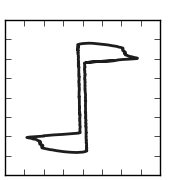

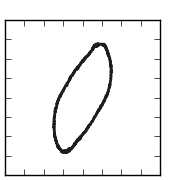

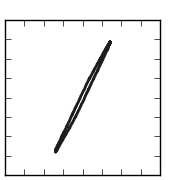

In [18]:
print_images = False; seaborn.reset_orig()
m = V.shape[0]; j = 0
temp = np.empty((m,32400)); p = random.sample(range(m),3)
for i in range(m):
    if print_images:
        fig = plt.figure(figsize=(2,2))
        plt.plot(I[i],V[i],linewidth=0.8,color='b'); plt.xlim([-4,4]); plt.ylim([-2,2]); 
        plt.savefig('pics_505_2/Ap_{}.png'.format(i))
        plt.close()
    else:
        im = Image.open('pics_505_1/Ap_{}.png'.format(i)).crop((20,0,200,200-20))
        im = im.convert('L')
        temp[i] = np.array(im).reshape((-1,))
        if i in p:
            display(im)
            j += 1
    pass
seaborn.set()
%matplotlib inline

After printing all the V-I pattern as images, the above script loads, cropes, convert to grayscale, and transforms those images (see examples) in arrays, in order to create a new matrix, `temp` (1074x32400), which will become the matrix of features.

### Fitting the classifier

To build a well-performing classifier to identify the appliance type based on its voltage and current signals as inputs, particularly the V-I profile at steady state, we start by evaluating different multi-class classifiers on the features matrix. To prevent overfitting, the dataset is randomly divided into three sub-sets: training, validation, and test. The models are fitted using the training subset and then the accuracy is tested on the validation subset. After this evaluation the best models are fine tuned and then tested using the testing subset. Since the objective is to accurately identify the type of an appliance based on its electrical signals, the following formula is used to measure accuracy:

$$Accurancy\space (Score) = \frac{Number\space of\space positive\space predictions}{Number\space of\space predictions}$$

In [29]:
X = temp; y = y_org
X_, X_test, y_, y_test = train_test_split(X,y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size=0.2)

Eight models are evaluated on the fractionated dataset. The function below fits the assigned model using the input training data and prints both, the score of the predictions on the input validation data and the fitting time. The score of the default classifier (i.e. a random prediction) is also printed for the sake of comparison. 

In [30]:
def eval_cfls(models,X,y,X_te,y_te):
    ss = []; tt = []
    for m in models:
        start = time.time()
        m.fit(X,y)
        ss.append(np.round(m.score(X_te,y_te),4))
        print(str(m).split('(')[0],': {}'.format(ss[-1]),'...Time: {} s'.format(np.round(time.time()-start,3)))
        tt.append(np.round(time.time()-start,3))
    return ss,tt

In [31]:
models = [OneVsRestClassifier(LinearSVC(random_state=0)),tree.ExtraTreeClassifier(),tree.DecisionTreeClassifier(),GaussianNB(),
          BernoulliNB(),GradientBoostingClassifier(), KNeighborsClassifier(),RandomForestClassifier()]

ss,tt = eval_cfls(models,X_train,y_train,X_cv,y_cv)
rand_guess = np.random.randint(0,len(set(y_train)),size=y_cv.shape[0])
print('Random Guess: {}'.format(np.round(np.mean(rand_guess == y_cv),4)))

OneVsRestClassifier : 0.9012 ...Time: 262.054 s
ExtraTreeClassifier : 0.7326 ...Time: 0.144 s
DecisionTreeClassifier : 0.8023 ...Time: 1.642 s
GaussianNB : 0.5058 ...Time: 1.566 s
BernoulliNB : 0.157 ...Time: 0.551 s
GradientBoostingClassifier : 0.843 ...Time: 822.472 s
KNeighborsClassifier : 0.8779 ...Time: 8.883 s
RandomForestClassifier : 0.8547 ...Time: 0.369 s
Random Guess: 0.0814


In general, the evaluated classifiers remarkably improve over the default classifier - expect for the Naive Bayes classifier using Bernoulli distributions (as expected given the input data). The one-vs-the-rest model, using a support vector machine estimator, is the one showing the highest accuracy on the validation subset. However, this classier, along with the Gradient Boosting (which also presents a good performance), takes significantly more time to fit than the others. On the contrary, the K-nearest-neighbors and Random Forest classifiers also achieve high accuracy but much faster. For these reasons, we are going to fine tune the main parameters of the latter two classifiers, re-train them, and then test again their performance on the testing subset.

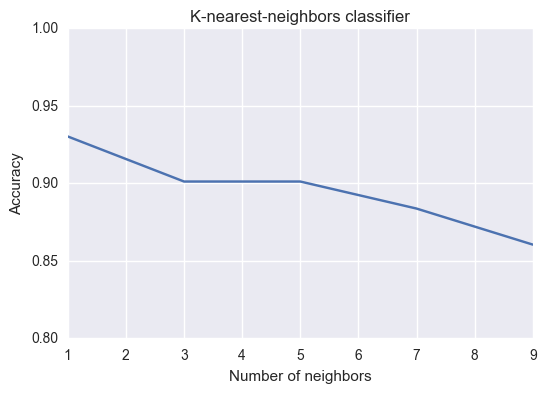

In [52]:
scores = []
for n in range(1,11,2):
    clf = KNeighborsClassifier(n_neighbors=n,weights='distance')
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_cv, y_cv))
plt.plot(range(1,11,2),scores); plt.xlabel('Number of neighbors'); plt.ylabel('Accuracy'); plt.ylim([0.8,1]);
plt.title('K-nearest-neighbors classifier');

For the KNN classifier, the above graph suggests that the less number of neighbors to consider, the better the accuracy. Therefore, we are going to set this parameter to have only one neighbor in the KNN classifier.

Having this new parameters, we re-trained both classifiers using the training and validation sub-sets, and test the fitted model on the testing set. 

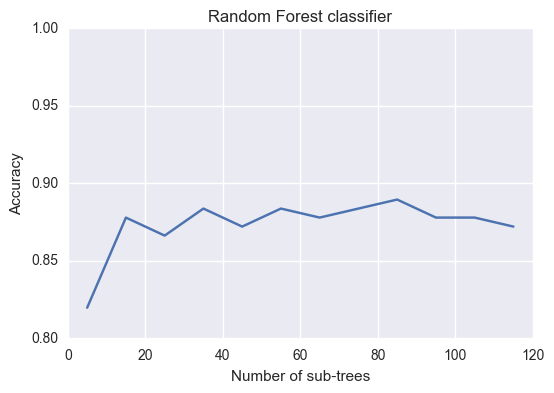

In [53]:
scores = []
for n in range(5,120,10):
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_cv, y_cv))
plt.plot(range(5,120,10),scores); plt.xlabel('Number of sub-trees'); plt.ylabel('Accuracy'); plt.ylim([0.8,1]);
plt.title('Random Forest classifier');

Although the characteristic of the Random Forest classifier entails that the shape of the above graph changes every time it is run, the general behavior suggests that having more than 10 sub-trees notably improves the performance of the classifier. Progressively increasing the number of trees after this threshold slightly improves the performance further, up to a point, around 70-90, when the accuracy starts decreasing. Therefore, we are going to set this parameter at 80 sub-trees.

In [55]:
models = [KNeighborsClassifier(n_neighbors=1,weights='distance'),RandomForestClassifier(n_estimators=80)]
eval_cfls(models,np.vstack([X_train,X_cv]),np.hstack([y_train,y_cv]),X_test,y_test);

KNeighborsClassifier : 0.9116 ...Time: 9.546 s
RandomForestClassifier : 0.8884 ...Time: 1.468 s


Both classifiers improved their performance after the tuning their parameters. KNN even outweighs the performance of the one-vs-the-rest classifier. Although the score of the Random Forest classifier slightly lags behind KNN, this fitting time of this one is 8x times faster than KNN.

### Testing the accuracy of the chosen classifiers

To further test the perfomance of both classifiers, we now perfom a random 10-fold cross-validation process on both models using the whole dataset.

In [58]:
cv_scores = []; X = temp; y = y_org
p = np.random.permutation(X.shape[0])
X = X[p]; y = y[p];
for m in models:
    start = time.time()
    cv_scores.append(cross_val_score(m, X, y, cv=10))
    print(str(m).split('(')[0],'average score: {}'.format(np.round(np.mean(cv_scores),3)),
         '...10-fold CV Time: {} s'.format(np.round(time.time()-start,3)))

KNeighborsClassifier average score: 0.934 ...10-fold CV Time: 76.215 s
RandomForestClassifier average score: 0.92 ...10-fold CV Time: 20.065 s


The results from the 10-fold cross-validation are very promising. Both models present more than 92% average accuracy and though KNN scores slightly higher, the Random Forest still shows significantly lesser fitting time.

### Identifying appliance type per house

One last step to test the performance of the KNN and Random Forest classifiers would be to predict or identify the type of appliances in particular house, based on the voltage and current signals, by training the model on the data from the rest of the houses. There are 55 homes surveyed and each appliance has a label indicating its corresponding house; hence, it is possible to split the data in this fashion. This is another kind of cross-validation.

In [13]:
def held_house(name,houses):
    X = temp; y = y_org;
    ids_te = houses[np.where(houses[:,0] == name),1].astype(int);
    ids_test,ids_train = [],[]
    for i,ID in enumerate(org_ids):
        if ID in ids_te:
            ids_test.append(i)
        else:
            ids_train.append(i)
    return ids_test,ids_train

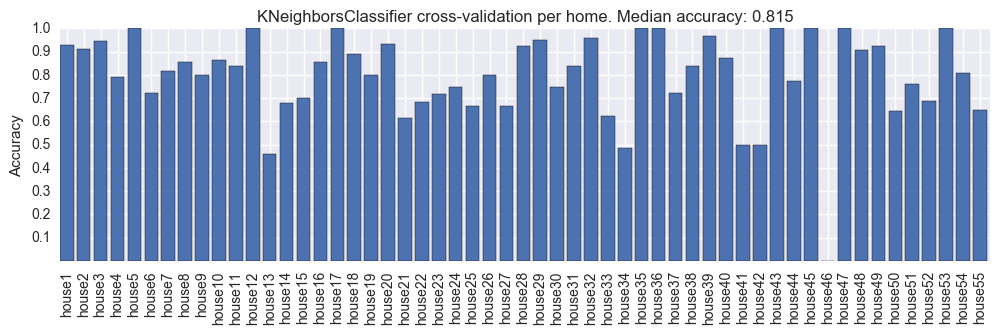

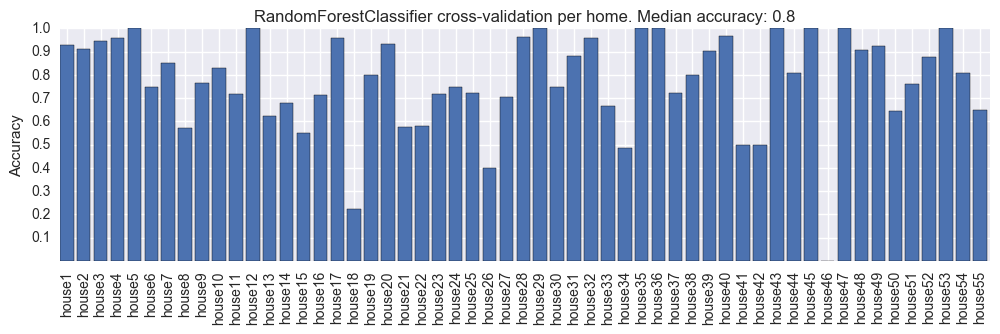

In [19]:
X = temp; y = y_org; h_names = ['house{}'.format(i+1) for i in range(len(set(houses[:,0])))]
scores = np.zeros((len(h_names),2))
for i,m in enumerate(models):
    ss = []
    for h in h_names:
        ids_test,ids_train = held_house(h,houses)
        X_train, X_test = X[ids_train], X[ids_test]; 
        y_train,y_test = y[ids_train],y[ids_test];        
        m.fit(X_train,y_train)
        ss.append(m.score(X_test,y_test))
    
    scores[:,i] = np.array(ss)
    plt.figure(figsize = (12,3))
    plt.bar(np.arange(len(h_names)),scores[:,i],width=0.8); plt.xlim([0,len(h_names)]); plt.yticks(np.arange(0.1,1.1,0.1)); 
    plt.ylabel('Accuracy');
    plt.title('{} cross-validation per home. Median accuracy: {}'.format(str(m).split('(')[0],
                                                                         np.round(np.median(scores[:,i]),3)))
    plt.xticks(np.arange(len(h_names))+0.4,h_names,rotation='vertical');
plt.show()

In [20]:
df = pd.DataFrame(np.array([np.mean(scores,axis=0),np.sum(scores == 1,axis=0),
                   np.sum(scores >= 0.9,axis=0),np.sum(scores < 0.8,axis=0),np.sum(scores < 0.5,axis=0)]),columns=['KNN','RF'])
df['Stats'] = ['Avg. accuracy','100% accuracy','Above 90%','Above 80%','Below 50%']; 
df.set_index('Stats',inplace=True); df.head()

,KNN,RF
Stats,,
Avg. accuracy,0.796108,0.775284
100% accuracy,9.000000,9.000000
Above 90%,19.000000,21.000000
Above 80%,23.000000,26.000000
Below 50%,3.000000,4.000000


The results of the cross-validation per home show an median accuracy above 80% for both classifiers. Out of the 55 home appliance predictions, 9 scored 100% accuracy and around 20 had scores above 90%. Only 3 and 2 houses had a scored below 50% using KNN and RF respectively.
In general, the presented outcome suggests that the chosen classifers work fairly well, although they perfom poorly for certain homes. In order to identify why is this the case, it is worth it to plot the predictions and actual type of a couple of those home appliances. 

Number of wrong predictions in house13: 5
Prediction: Laptop , Actual: Microwave
Prediction: Laptop , Actual: Microwave


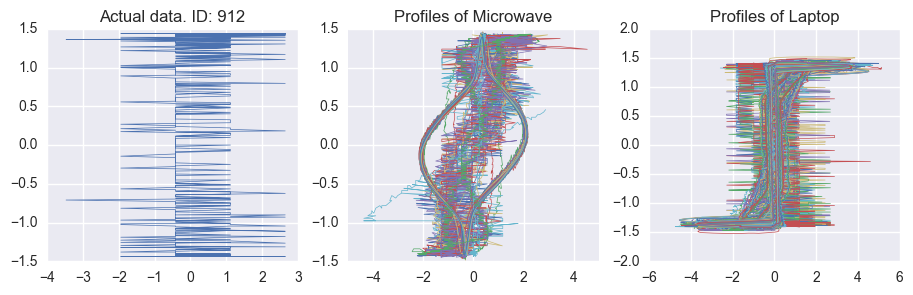

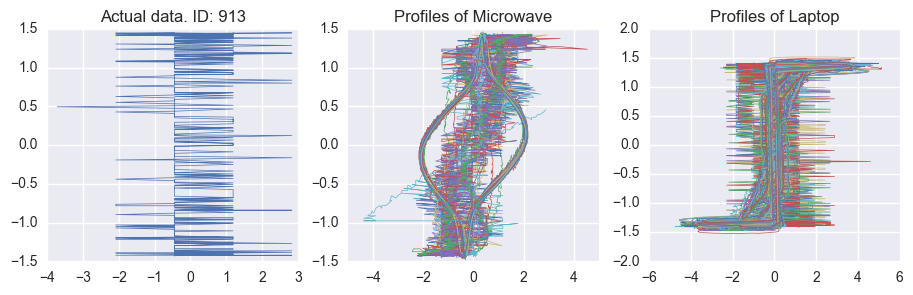

In [21]:
X = temp; y = y_org;
ids_test, ids_train = held_house('house46',houses)
X_train, X_test = X[ids_train], X[ids_test]; y_train,y_test = y[ids_train],y[ids_test]; 
V_,V_test = V[ids_train],V[ids_test]; I_,I_test = I[ids_train],I[ids_test]; org_ids_test = np.array(org_ids)[ids_test]
models[1].fit(X_train,y_train)
pred = models[1].predict(X_test)
items = np.where(pred != y_test)[0]
print('Number of wrong predictions in house13: {}'.format(len(items)))
for ids in items[:2]:
    print('Prediction: '+ types[int(pred[ids])],', Actual: '+types[int(y_test[ids])])
    fig,ax = plt.subplots(1,3,figsize=(11,3))
    ax[0].plot(I_test[ids],V_test[ids],linewidth=0.5); ax[0].set_title('Actual data. ID: {}'.format(org_ids_test[ids]));
    ax[1].plot(I_[y_train==y_test[ids]].T,V_[y_train==y_test[ids]].T,linewidth=0.5); 
    ax[1].set_title('Profiles of {}'.format(types[int(y_test[ids])]))
    ax[2].plot(I_[y_train==pred[ids]].T,V_[y_train==pred[ids]].T,linewidth=0.5); 
    ax[2].set_title('Profiles of {}'.format(types[int(pred[ids])])); 

By running the above script over different wrong predictions we noticed that many of them correspond to signals either in transient or sub-transient state; which means that the shape of the V-I plot is not fully defined, so identifying the appliance type based on such image is very hard even for human eye. Furthermore, in several homes the list of associated appliances contain the same appliance sampled in different times. For example, in home46, in which we get an accuracy of 0%, the only signals correspond to a microwave whose V-I profile is very fuzzy. Therefore, in cases like this one, the classifiers are meant to failed repeatedly in a single house.  

### Conclusions and future work

The present notebook presents a data-driven approach to the problem of identifying home appliances type based on their corresponding electrical signals. Different multi-class classifiers are trained and tested on the PLAID dataset in order to identify the most accurate and less computationally expensive models. An image recognition approach of Voltage-Current profiles in steady state is used to model the inputs of the appliance classifiers. Based on the analyses undertaken we are able to identify some common patterns and draw conclusions about the two best performed classifiers identified in terms of time and accuracy, K-nearest-neighbors and Random Forest Decision Tree:
- After fine tuning their corresponding parameters on a training sub-set, the average accuracy of KNN and RF, applying 10-fold cross-validation, is greater than 91%.
- The One-vs-the-rest and Gradient Boosting Decision Trees classifiers also show high accuracy; however, the fitting time is in the order of minutes (almost 15 min. for Gradient Boosting), whereas KNN and RF take seconds to do the job. 
- Though KNN scores slightly higher than RF, the latter takes significantly shorter fitting time (about 8x time less).
- While high accuracy in both classifiers is achieved using traditional cross-validation techniques, when applying cross-validation per individual home, the accuracy decreased to 80% on average.      
- While debugging the classifers we noticed that many of the input signals of current and voltage do not reach steady state in different appliances. Therefore, their corresponding V-I profile is not well defined which makes the prediction harder even for a human expert eye. We also noticed that in several homes, the list of associated appliances contain the same appliance sampled in different times. Therefore, in those cases the classifiers are meant to failed repeatedly in a single house.  

The following task are proposed as future work in order to improve the performance of the trained appliance classifiers:
- _Collect more data_: The figure bellow shows the training and test accuracy evolution of the RF classifier with respect to the number of samples. While only slight increments are realized after 700-800 samples, it seems that there is still room for improvement in this sense.   

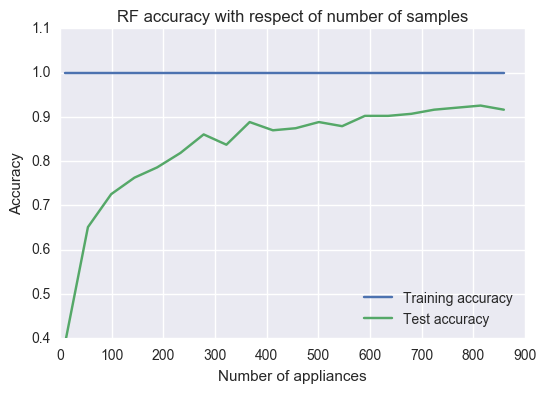

In [22]:
def plot_clf_samples(model,X,X_te,y,y_te,n):
    model.fit(X[:n], y[:n])
    return np.array([model.score(X[:n], y[:n]), model.score(X_te, y_te)])

X = temp; y = y_org;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
models[1].fit(X_train,y_train)
models[1].score(X_test, y_test)
nsamples = [int(x) for x in np.linspace(10, X_train.shape[0], 20)]
errors = np.array([plot_clf_samples(clf, X_train, X_test, y_train,y_test, n) for n in nsamples])
plt.plot(nsamples, errors[:,0], nsamples, errors[:,1]); plt.xlabel('Number of appliances'); plt.ylabel('Accuracy'); 
plt.ylim([0.4,1.1])
plt.legend(['Training accuracy','Test accuracy'],loc=4); plt.title('RF accuracy with respect of number of samples');

- _Processing of data_: Identifying intervals of steady state behavior signals for each appliance would be very useful to improve the accuracy of the classifiers. Therefore, further work should be done to process the data before training the classifiers.
- _Adding engineered features_: While an image recognition approach was employed in this analysis, the pure data of currents and voltages do contain a big deal of useful information for classification. The next step would be to find ways to combined both types of features.
- _Apply deep learning algorithms_: Since we are working with images, and given that the machine learning community has done impressive work in image recognition using neural networks, it would be worth it to apply a specialized deep learning architecture to the dataset of images produced. However, in order to do produce meaningful better results, we will need even more samples per appliance type.
